In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import pyterrier as pt
import pandas as pd

from src.neural_ranker.ranker import NeuralRanker
from src.neural_ranker.produce_rankings import IRDataset, Processor
from domain_adaptation import self_training_domain_adaptation
from main import llm_ranker
from eval import Model, evaluate_rankings
from openai import OpenAI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\viv16\Documents\GitHub\ranker_ir\main.py:311: SyntaxWarning: invalid escape sequence '\l'
  # Rank the results based on the score
c:\Users\viv16\Documents\GitHub\ranker_ir\main.py:312: SyntaxWarning: invalid escape sequence '\l'
  df_top100_zero = df_top100_zero.sort_values(by=["qid", "score"], ascending=[True, False])


In [18]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_mem_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    gpu_mem_reserved = torch.cuda.memory_reserved(0) / 1024**3
    gpu_mem_allocated = torch.cuda.memory_allocated(0) / 1024**3
    gpu_mem_free = gpu_mem_total - gpu_mem_reserved
    print(f"GPU Memory: Total: {gpu_mem_total:.2f}GB, Reserved: {gpu_mem_reserved:.2f}GB, "
        f"Allocated: {gpu_mem_allocated:.2f}GB, Free: {gpu_mem_free:.2f}GB")

Using device: cuda
GPU Memory: Total: 4.00GB, Reserved: 0.00GB, Allocated: 0.00GB, Free: 4.00GB


Before you move forward, please make sure that you have run the base neural ranker and have evaluated the neural ranker from notebook experiment.ipynb.

In [19]:
bair = 'irds:beir/trec-covid'
cord19 = 'irds:cord19/trec-covid'

bair_dataset = IRDataset(bair, max_docs=None)
cord19_dataset = IRDataset(cord19, max_docs=None)

Loading up to None documents from irds:beir/trec-covid...


beir/trec-covid documents: 100%|██████████| 171332/171332 [00:01<00:00, 133430.69it/s]
Loading Documents: 171332it [00:01, 133430.69it/s]


Loading up to None documents from irds:cord19/trec-covid...


cord19/trec-covid documents: 100%|██████████| 192509/192509 [00:01<00:00, 142880.75it/s]
Loading Documents: 192509it [00:01, 142687.24it/s]


In [58]:
evaluate_rankings(model=Model.BASE, dataset_name=cord19)

Evaluating rankings with metrics@10...
Loaded 7750000 ranking entries

=== Evaluation Results ===
map: 0.1366
ndcg: 0.5261
ndcg_cut_10: 0.6390
P_10: 0.6680
recall_10: 0.0159
recip_rank: 0.8334

Evaluation results saved to evaluation_results/base\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0849
    recip_rank: 0.5000
    P_10: 0.4000
    recall_10: 0.0057
    ndcg: 0.4704
    ndcg_cut_10: 0.2577
-------------------------

Query 2:
    map: 0.0437
    recip_rank: 0.5000
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.4832
    ndcg_cut_10: 0.5305
-------------------------

Query 3:
    map: 0.1205
    recip_rank: 1.0000
    P_10: 0.8000
    recall_10: 0.0123
    ndcg: 0.5240
    ndcg_cut_10: 0.8087
-------------------------

Query 4:
    map: 0.0328
    recip_rank: 0.1000
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.4270
    ndcg_cut_10: 0.0636
-------------------------

Query 5:
    map: 0.0933
    recip_rank: 0.2500
    P_10: 0.4000
    recall_10: 

{'map': 0.1366471129829117,
 'ndcg': 0.5261215627216107,
 'ndcg_cut_10': 0.6390147416149431,
 'P_10': 0.6679999999999999,
 'recall_10': 0.01592356923568684,
 'recip_rank': 0.8334285714285714}

In [47]:
# llm_input_creator(cord19_dataset)
llm_ranker(cord19_dataset)

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Zero: Query 1 and Docno nm2ubi13 processed. Result: 175.5
Few: Query 1 and Docno nm2ubi13 processed. Result: 156.782
Zero: Query 1 and Docno aeogp8c7 processed. Result: 160.5
Few: Query 1 and Docno aeogp8c7 processed. Result: 176.543
Zero: Query 1 and Docno zxudiyj4 processed. Result: 155.5
Few: Query 1 and Docno zxudiyj4 processed. Result: 187.543
Zero: Query 1 and Docno mo4luyx6 processed. Result: 175.5
Few: Query 1 and Docno mo4luyx6 processed. Result: 170.543
Zero: Query 1 and Docno o4njvi62 processed. Result: 120.5
Few: Query 1 and Docno o4njvi62 processed. Result: 121.578
Zero: Query 1 and Docno r2ynbnxx processed. Result: 170.5
Few: Query 1 and Docno r2ynbnxx processed. Result: 177.543
Zero: Query 1 and Docno ov3r7izq processed. Result: 180.5
Few: Query 1 and Docno ov3r7izq processed. Result: 177.893
Zero: Query 1 and D

In [53]:
dataframe_few = pd.read_csv('rankings/llm_few_rankings_unsorted.csv')
dataframe_zero = pd.read_csv('rankings/llm_zero_rankings_unsorted.csv')

df_top100_few_sorted = (
    dataframe_few
    .sort_values(by=["qid", "score"], ascending=[True, False])
    .reset_index(drop=True)
)

df_top100_zero_sorted = (
    dataframe_zero
    .sort_values(by=["qid", "score"], ascending=[True, False])
    .reset_index(drop=True)
)

# Save the sorted DataFrame to a CSV file
df_top100_few_sorted.to_csv('rankings/llm_few_rankings.csv', index=False)
df_top100_zero_sorted.to_csv('rankings/llm_zero_rankings.csv', index=False)

We now request a batch call to be made to OpenAI. Unfortunately, OpenAI has a token limit of 2.000.000, so we need to upload a maximum of 3 batches at the same time. After these batches are completed, we can move to the next 3 etc.

In [54]:
evaluate_rankings(model=Model.LLMZERO, dataset_name=cord19)

Evaluating rankings with metrics@10...
Loaded 5000 ranking entries

=== Evaluation Results ===
map: 0.0634
ndcg: 0.1558
ndcg_cut_10: 0.6601
P_10: 0.7080
recall_10: 0.0171
recip_rank: 0.8633

Evaluation results saved to evaluation_results/llm_zero\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0367
    recip_rank: 1.0000
    P_10: 0.8000
    recall_10: 0.0114
    ndcg: 0.0924
    ndcg_cut_10: 0.6735
-------------------------

Query 2:
    map: 0.0326
    recip_rank: 1.0000
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.1184
    ndcg_cut_10: 0.6867
-------------------------

Query 3:
    map: 0.0400
    recip_rank: 1.0000
    P_10: 0.4000
    recall_10: 0.0061
    ndcg: 0.1338
    ndcg_cut_10: 0.4758
-------------------------

Query 4:
    map: 0.0037
    recip_rank: 0.2500
    P_10: 0.2000
    recall_10: 0.0035
    ndcg: 0.0296
    ndcg_cut_10: 0.0866
-------------------------

Query 5:
    map: 0.0171
    recip_rank: 0.5000
    P_10: 0.4000
    recall_10:

{'map': 0.06339703373093747,
 'ndcg': 0.15581957305516128,
 'ndcg_cut_10': 0.6600684877877425,
 'P_10': 0.7080000000000003,
 'recall_10': 0.017073210016968456,
 'recip_rank': 0.8633333333333334}

In [55]:

evaluate_rankings(model=Model.LLMFEW, dataset_name=cord19)

Evaluating rankings with metrics@10...
Loaded 5000 ranking entries

=== Evaluation Results ===
map: 0.0621
ndcg: 0.1537
ndcg_cut_10: 0.6231
P_10: 0.6700
recall_10: 0.0159
recip_rank: 0.8429

Evaluation results saved to evaluation_results/llm_few\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0320
    recip_rank: 1.0000
    P_10: 0.7000
    recall_10: 0.0100
    ndcg: 0.0863
    ndcg_cut_10: 0.4942
-------------------------

Query 2:
    map: 0.0264
    recip_rank: 0.2500
    P_10: 0.4000
    recall_10: 0.0119
    ndcg: 0.0954
    ndcg_cut_10: 0.3102
-------------------------

Query 3:
    map: 0.0385
    recip_rank: 1.0000
    P_10: 0.4000
    recall_10: 0.0061
    ndcg: 0.1257
    ndcg_cut_10: 0.3380
-------------------------

Query 4:
    map: 0.0072
    recip_rank: 1.0000
    P_10: 0.2000
    recall_10: 0.0035
    ndcg: 0.0379
    ndcg_cut_10: 0.1795
-------------------------

Query 5:
    map: 0.0213
    recip_rank: 1.0000
    P_10: 0.5000
    recall_10: 

{'map': 0.06206734404300872,
 'ndcg': 0.15369543517787854,
 'ndcg_cut_10': 0.6230659073079927,
 'P_10': 0.6699999999999998,
 'recall_10': 0.015939967496318125,
 'recip_rank': 0.8428888888888889}

In [59]:
base_results = pd.read_csv('evaluation_results/base/evaluation_results.csv')
llm_zero_results = pd.read_csv('evaluation_results/llm_zero/evaluation_results.csv')
llm_few_results = pd.read_csv('evaluation_results/llm_few/evaluation_results.csv')

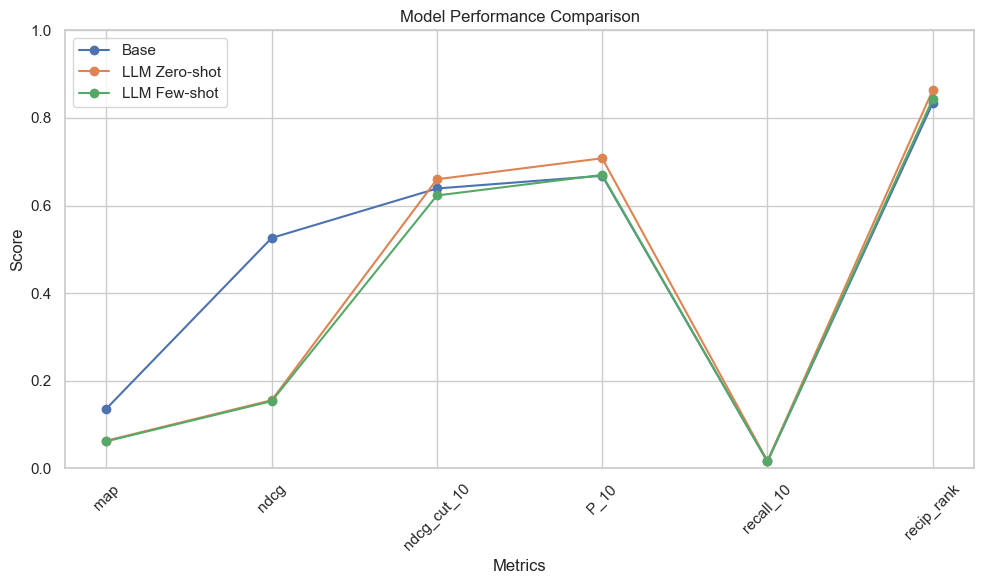

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['map', 'ndcg', 'ndcg_cut_10', 'P_10', 'recall_10', 'recip_rank']

# create a line for each model that goes through the metrics results
# and add the model name as a label
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for model_results, label in zip([base_results, llm_zero_results, llm_few_results], ['Base', 'LLM Zero-shot', 'LLM Few-shot']):
    plt.plot(metrics, model_results[metrics].values.flatten(), marker='o', label=label)

plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()